<a href="https://colab.research.google.com/github/ksgr5566/News-Headline-Generator/blob/main/Headline_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning

In [2]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [4]:
pl.seed_everything(42)

Global seed set to 42


42

# Preparing Data

Dataset link: https://huggingface.co/datasets/valurank/News_headlines

In [7]:
!pip install --upgrade google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client


     -------------------------------------- 181.9/181.9 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 12.3/12.3 MB 804.0 kB/s eta 0:00:00
     -------------------------------------- 123.8/123.8 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 96.9/96.9 kB 1.4 MB/s eta 0:00:00
     ------------------------------------ 121.4/121.4 kB 788.7 kB/s eta 0:00:00
     -------------------------------------- 430.5/430.5 kB 2.1 MB/s eta 0:00:00
     -------------------------------------- 227.6/227.6 kB 1.3 MB/s eta 0:00:00
     -------------------------------------- 151.7/151.7 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 62.6/62.6 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.14
    Uninstalling urllib3-1.26.14:
      Successfully uninstalled urllib3-1.26.14
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:
  

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.1.2 requires requests<2.29,>=2.24.0, but you have requests 2.31.0 which is incompatible.
conda-repo-cli 1.0.27 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.27 requires nbformat==5.4.0, but you have nbformat 5.7.0 which is incompatible.
conda-repo-cli 1.0.27 requires requests==2.28.1, but you have requests 2.31.0 which is incompatible.


In [8]:
from google.oauth2 import service_account
from googleapiclient.discovery import build


In [10]:
SCOPES = ['https://www.googleapis.com/auth/drive']
SERVICE_ACCOUNT_FILE = 'your-service-account-key.json'  # Replace with your JSON key file

# Authenticate using the service account credentials
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=SCOPES
)

# Create a Google Drive API service
drive_service = build('drive', 'v3', credentials=credentials)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# The above code will mount Google Drive to '/content/drive'


FileNotFoundError: [Errno 2] No such file or directory: 'your-service-account-key.json'

In [5]:
from google.colab import drive
# mount your drive to colab where your dataset is present
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
# path in drive where the dataset is present
df = pd.read_csv("drive/MyDrive/news_headlines.csv", encoding="latin-1")
df = df.dropna()
df.head()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
df.shape

(13445, 2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df, rest_df = train_test_split(df, test_size=0.2)
test_df, val_df = train_test_split(rest_df, test_size=0.5)

# train_df = train_df.head()
# test_df = test_df.head()
# val_df = val_df.head()
train_df.shape, test_df.shape, val_df.shape

((10756, 2), (1344, 2), (1345, 2))

In [ ]:
MODEL_NAME = "t5-base" #smallest t5 model

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, model_max_length=512) # , model_max_length=10000

In [ ]:
article_token_counts, headline_token_counts = [], []

for _, row in train_df.iterrows():
    article_token_count = len(tokenizer.encode(row["article"]))
    article_token_counts.append(article_token_count)

    headline_token_count = len(tokenizer.encode(row["headline"]))
    headline_token_counts.append(headline_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (746 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
df["article"].str.len().max(), df["headline"].str.len().max()

(33246, 157)

Text(0.5, 1.0, 'headline text token counts')

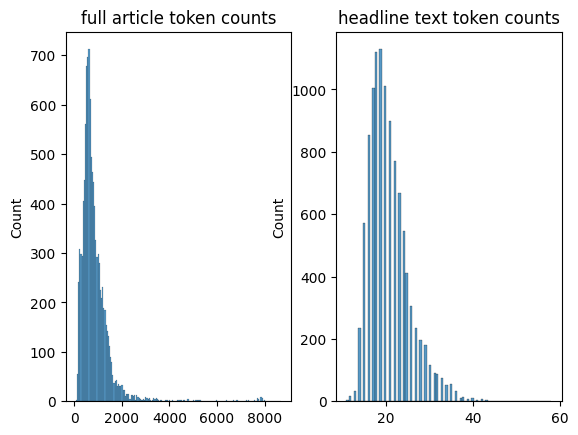

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(article_token_counts, ax=ax1)
ax1.set_title("full article token counts")

sns.histplot(headline_token_counts, ax=ax2)
ax2.set_title("headline text token counts")

In [ ]:
example = df.iloc[0]["article"]
example

'The logo of cryptocurrency exchange Binance displayed on a smartphone with the word "cancelled" on a computer screen in the background.Budrul Chukrut | SOPA Images | LightRocket via Getty ImagesBinance said Monday that it is temporarily pausing bitcoin withdrawals "due to a stuck transaction causing a backlog."At first, Binance founder and CEO Changpeng Zhao said in a tweet that the issue would be fixed within 30 minutes. But he later amended that to say, "Likely this is going to take a bit longer to fix than my initial estimate." He added that, "[t]his is only impacting the Bitcoin network," and that holders "can still withdraw Bitcoin on other networks like BEP-20.""Funds are SAFU," he added. The acronym stands for "secure asset fund for users," which is a fund the company established in 2018 to help safeguard users.The news comes as bitcoin tumbled more than 10% on Monday, breaking below $24,000 and sinking to the lowest level since December 2020.The largest cryptocurrency has been

In [ ]:
tokenizer.tokenize(example)

['▁The',
 '▁logo',
 '▁of',
 '▁cryptocurrency',
 '▁exchange',
 '▁Bin',
 'ance',
 '▁displayed',
 '▁on',
 '▁',
 'a',
 '▁smartphone',
 '▁with',
 '▁the',
 '▁word',
 '▁"',
 'can',
 'cel',
 'led',
 '"',
 '▁on',
 '▁',
 'a',
 '▁computer',
 '▁screen',
 '▁in',
 '▁the',
 '▁background',
 '.',
 'Bu',
 'd',
 'rul',
 '▁Chu',
 'k',
 'rut',
 '▁|',
 '▁SO',
 'PA',
 '▁Images',
 '▁|',
 '▁Light',
 'Rock',
 'e',
 't',
 '▁via',
 '▁G',
 'etty',
 '▁Images',
 'B',
 'in',
 'ance',
 '▁said',
 '▁Monday',
 '▁that',
 '▁it',
 '▁is',
 '▁temporarily',
 '▁pa',
 'using',
 '▁bitcoin',
 '▁withdrawal',
 's',
 '▁"',
 'du',
 'e',
 '▁to',
 '▁',
 'a',
 '▁stuck',
 '▁transaction',
 '▁',
 'causing',
 '▁',
 'a',
 '▁back',
 'log',
 '."',
 'A',
 't',
 '▁first',
 ',',
 '▁Bin',
 'ance',
 '▁founder',
 '▁and',
 '▁CEO',
 '▁Chang',
 'pen',
 'g',
 '▁Zhao',
 '▁said',
 '▁in',
 '▁',
 'a',
 '▁tweet',
 '▁that',
 '▁the',
 '▁issue',
 '▁would',
 '▁be',
 '▁fixed',
 '▁within',
 '▁30',
 '▁minutes',
 '.',
 '▁But',
 '▁',
 'he',
 '▁later',
 '▁amended',
 '▁

In [ ]:
tokenizer.encode(example)

[37,
 3554,
 13,
 19432,
 2509,
 7617,
 663,
 6099,
 30,
 3,
 9,
 5626,
 28,
 8,
 1448,
 96,
 1608,
 7125,
 1361,
 121,
 30,
 3,
 9,
 1218,
 1641,
 16,
 8,
 2458,
 5,
 7793,
 26,
 5155,
 16636,
 157,
 6830,
 1820,
 5055,
 3965,
 15180,
 1820,
 2892,
 23349,
 15,
 17,
 1009,
 350,
 16142,
 15180,
 279,
 77,
 663,
 243,
 2089,
 24,
 34,
 19,
 18223,
 2576,
 9381,
 16623,
 11905,
 7,
 96,
 1259,
 15,
 12,
 3,
 9,
 6229,
 5878,
 3,
 5885,
 3,
 9,
 223,
 2152,
 535,
 188,
 17,
 166,
 6,
 7617,
 663,
 7174,
 11,
 4071,
 24187,
 3208,
 122,
 30680,
 243,
 16,
 3,
 9,
 10657,
 24,
 8,
 962,
 133,
 36,
 3599,
 441,
 604,
 676,
 5,
 299,
 3,
 88,
 865,
 21012,
 24,
 12,
 497,
 6,
 96,
 434,
 5208,
 120,
 48,
 19,
 352,
 12,
 240,
 3,
 9,
 720,
 1200,
 12,
 2210,
 145,
 82,
 2332,
 7037,
 535,
 216,
 974,
 24,
 6,
 96,
 6306,
 17,
 908,
 10193,
 19,
 163,
 1113,
 53,
 8,
 9310,
 1229,
 976,
 11,
 24,
 14733,
 96,
 1608,
 341,
 14510,
 9310,
 30,
 119,
 5275,
 114,
 6554,
 345,
 7988,
 535,
 121,


In [ ]:
class NewsHeadlineDataset(Dataset):

    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        article_max_token_len: int = 512,
        headline_max_token_len: int = 128
    ):

        self.tokenizer = tokenizer
        self.data = data
        self.article_max_token_len = article_max_token_len
        self.headline_max_token_len = headline_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        article = data_row["article"]

        article_encoding = tokenizer(
            article,
            max_length=self.article_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        headline_encoding = tokenizer(
            data_row["headline"],
            max_length=self.headline_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        labels = headline_encoding["input_ids"]
        # giving padding (encoded with 0s) value of -100 so that it doesn't get counted in loss func, from docs
        labels[labels == 0] = -100

        return dict(
            article=article,
            headline=data_row["headline"],
            article_input_ids=article_encoding["input_ids"].flatten(),
            article_attention_mask=article_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=headline_encoding["attention_mask"].flatten()
        )

In [ ]:
class NewsHeadlineDataModule(pl.LightningDataModule):

    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        val_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int = 8,
        article_max_token_len: int = 512,
        headline_max_token_len: int = 128
    ):

        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df

        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.article_max_token_len = article_max_token_len
        self.headline_max_token_len = headline_max_token_len

    def setup(self, stage=None):
        self.train_dataset = NewsHeadlineDataset(
            self.train_df,
            self.tokenizer,
            self.article_max_token_len,
            self.headline_max_token_len
        )

        self.test_dataset = NewsHeadlineDataset(
            self.test_df,
            self.tokenizer,
            self.article_max_token_len,
            self.headline_max_token_len
        )

        self.val_dataset = NewsHeadlineDataset(
            self.val_df,
            self.tokenizer,
            self.article_max_token_len,
            self.headline_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True, # used for training
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

# Model Building

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

<IPython.core.display.Javascript object>

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 8

data_module = NewsHeadlineDataModule(train_df, test_df, val_df, tokenizer, batch_size=BATCH_SIZE)

In [ ]:
class NewsHeadlineModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        self.val_loss = []
        self.val_loss_epoch = []

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        # if we have labels we are going to have decoder_attenttion_mask which is calculated from the summary encoding and the labels

        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch["article_input_ids"]
        attention_mask = batch["article_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["article_input_ids"]
        attention_mask = batch["article_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.val_loss.append(loss)
        return loss

    def validation_epoch_end(self, outputs):
      avg = sum(self.val_loss)/len(self.val_loss)
      self.val_loss_epoch.append(avg)
      self.val_loss = []
      # avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
      # self.logger.experiment.add_scalar('loss',avg_loss, self.current_epoch)

    def test_step(self, batch, batch_idx):
        input_ids = batch["article_input_ids"]
        attention_mask = batch["article_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

In [ ]:
model = NewsHeadlineModel()

In [36]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="news-headline")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=1  # Specify the number of GPUs to use (if applicable)
)


TypeError: ignored

In [ ]:
trainer.fit(model, data_module)

In [ ]:
a = model.val_loss_epoch

In [ ]:
a = torch.Tensor(a).cpu()

In [ ]:
plt.plot([0,1,2,3,4,5,6,7,8,9,10], a)

In [ ]:
# trained_model = NewsHeadlineModel.load_from_checkpoint(
#     trainer.callbacks[3].best_model_path # model_checkpoint at index 3 in callbacks array
# )

# path to the checkpoint needs to be provided here
custom_path = "/content/drive/MyDrive/neney/best-checkpoint.ckpt"

trained_model = NewsHeadlineModel.load_from_checkpoint(custom_path)

trained_model.freeze()

In [ ]:
def generate_headline(text):
  text_encoding = tokenizer(
      text,
      max_length=512,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      add_special_tokens=True,
      return_tensors="pt"
  )

  generated_ids = trained_model.model.generate(
      input_ids=text_encoding["input_ids"],
      attention_mask=text_encoding["attention_mask"],
      max_length=150,
      num_beams=2, # beam search
      repetition_penalty=2.5,
      length_penalty=1.0,
      early_stopping=True # To speed up the process
  )

  preds = [
      tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
      for gen_id in generated_ids
  ]

  return "".join(preds)

## Prediction examples

In [ ]:
sample_row = val_df.iloc[0]
text = sample_row["article"]

In [ ]:
print(len(text.split()))
text

In [ ]:
sample_row["headline"]

In [ ]:
generate_headline(text)

In [ ]:
sample_row = val_df.iloc[10]
text = sample_row["article"]

In [ ]:
print(len(text.split()))
text

In [ ]:
sample_row["headline"]

In [ ]:
generate_headline(text)

## Rouge Evaluation

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge
ROUGE = Rouge()

In [ ]:
sample_row = val_df.iloc[1]
text = sample_row["article"]
reference = sample_row["headline"]
candidate = generate_headline(text)

In [ ]:
x = ROUGE.get_scores(candidate, reference)
x[0]

In [ ]:
type(x[0]["rouge-1"])

In [ ]:
len(val_df.index)


In [ ]:
res = {}
res['rouge-1'] = {}
res['rouge-2'] = {}
res['rouge-l'] = {}
for key in res:
  res[key]['r'] = 0
  res[key]['p'] = 0
  res[key]['f'] = 0
for index in range(len(val_df.index)):
  sample_row = val_df.iloc[index]
  text = sample_row["article"]
  reference = sample_row["headline"]
  candidate = generate_headline(text)
  score = ROUGE.get_scores(candidate, reference)
  for key in res:
    res[key]['r'] += score[0][key]['r']
    res[key]['p'] += score[0][key]['p']
    res[key]['f'] += score[0][key]['f']
for key in res:
  res[key]['r'] /= len(val_df.index)
  res[key]['p'] /= len(val_df.index)
  res[key]['f'] /= len(val_df.index)
res

## Semantic Similarity

In [ ]:
for index in range(len(val_df.index)):
  sample_row = val_df.iloc[index]
  text = sample_row["article"]
  reference = sample_row["headline"]
  candidate = generate_headline(text)
  with open("predictions.txt","a+") as f:
    f.write(candidate+"\n")

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
cosine_similarity = 0
dot_product = 0
with open("predictions.txt", "r") as f:
  lines = f.readlines()
  lines = [line.strip() for line in lines]
  for index, line in enumerate(lines):
     sample_row = val_df.iloc[index]
     reference = sample_row["headline"]
     en_1 = sentence_model.encode(reference)
     en_2 = sentence_model.encode(line)
     cosine_sim_result = util.cos_sim(en_1, en_2)
     cosine_sim_result_float = cosine_sim_result.item()
     dot_product_result = util.dot_score(en_1, en_2)
     dot_product_result_float = dot_product_result.item()
     cosine_similarity += cosine_sim_result_float
     dot_product += dot_product_result_float
  cosine_similarity /= len(val_df.index)
  dot_product /= len(val_df.index)
print(f'Cosine Similarity: {cosine_similarity} \nDot Product: {dot_product}')